# Notebook Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

from IPython.display import display
from scipy.stats.mstats import winsorize

In [3]:
# all warning related
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Functions

In [7]:
def corr_plotter(corrmatrix_dataframe:pd.DataFrame, title:str):
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corrmatrix_dataframe, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corrmatrix_dataframe, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  plt.title(title)

# Data Importation

In [4]:
path_ = '/Volumes/GoogleDrive/My Drive/_599/Capstone/Data/pure_ripa_final.csv'
df = pd.read_csv(path_)
print('DataFrame shape', df.shape)
df.head(3)

DataFrame shape (652452, 27)


,stop_id,pid,reason_for_stop,exp_years,date_stop,time_stop,stopduration,officer_assignment_key,assignment,beat,...,resultkey,result,race,date,time_period,light,month,day_of_week,hour_stopped,temp
0,10000,1,Traffic Violation,26,2018-07-15,19:31:37,5,1,"Patrol, traffic enforcement, field operations",313.0,...,3,Citation for infraction,White,2018-07-15,2,1,7,6,19,74.5
1,10001,1,Reasonable Suspicion,1,2018-07-15,16:16:00,120,1,"Patrol, traffic enforcement, field operations",721.0,...,6,Custodial Arrest without warrant,Hispanic/Latino/a,2018-07-15,1,1,7,6,16,80.7
2,10002,1,Reasonable Suspicion,10,2018-07-15,19:40:37,30,1,"Patrol, traffic enforcement, field operations",124.0,...,10,Psychiatric hold,White,2018-07-15,2,1,7,6,19,74.5


# Column Null Ratios

In [6]:
nulls_ = (df.isnull().sum() * 100 / len(df)).to_frame().reset_index()
nulls_.columns = ['feature', '%_missing']
nulls_.sort_values('feature')


,feature,%_missing
8,assignment,0.000000
9,beat,0.000000
20,date,0.000000
4,date_stop,0.000000
24,day_of_week,0.000000
3,exp_years,0.000000
15,gend,0.000000
14,gender_nonconforming,0.000000
25,hour_stopped,0.000000
10,isstudent,0.000000


Perceived gender is our only feature with missing rows.

### Perceived Gender VS Gender 
Let's first look at something related but confusing.

In [5]:
df['gender_nonconforming'].value_counts()

0    651982
1       470
Name: gender_nonconforming, dtype: int64

So we have 470 records, where the suspect is gender_noncomforming.  But then we look at the following.

In [6]:
df[['perceived_gender', 'gend']].head()

,perceived_gender,gend
0,Male,1
1,Male,1
2,Male,1
3,Female,2
4,Female,2


In [7]:
gender = 'Female'
perc_bool = (df['perceived_gender'] == gender) 
gend_bool = (df['gend'] == 1)
df[perc_bool & gend_bool].shape

(0, 27)

In [8]:
gender = 'Male'
perc_bool = (df['perceived_gender'] == gender) 
gend_bool = (df['gend'] == 1)
df[perc_bool & gend_bool].shape

(474935, 27)

No officers assumed a woman is a man and all men are men.

In [9]:
gender = 'Female'
perc_bool = (df['perceived_gender'] == gender) 
gend_bool = (df['gend'] == 2)
df[perc_bool & gend_bool].shape

(175434, 27)

In [10]:
gender = 'Male'
perc_bool = (df['perceived_gender'] == gender) 
gend_bool = (df['gend'] == 2)
df[perc_bool & gend_bool].shape

(0, 27)

Again, same outcome but in reverse.  Then we have the following.

In [11]:
df['perceived_lgbt'].value_counts()

No     635742
Yes     16710
Name: perceived_lgbt, dtype: int64

At least we have found out that perceived gender doesn't deviate from the gender feature, rendering perceived gender string feature to be a redundant copy of gender but in integer format. 


# More Feature Engineering
There are other engineereed features created within the DataPrep notebook.

In [12]:
df['month'] = df['date_stop'].apply(lambda row: int(row[5:7]))
df['day_of_week'] = df['date_stop'].astype('datetime64').dt.day_of_week
df['hour_stopped'] = df['time_stop'].apply(lambda row: int(row[:2]))

# Types of Features

In [13]:
ordinal_features =  ['day_of_week',
                    'hour_stopped',
                    'month',
                    'time_period']

nominal_features = ['gend',
                    'isstudent',
                    'light',
                    'officer_assignment_key',
                    'perceived_lgbt',
                    'race']

numeric_features = ['exp_years',
                    'perceived_age',
                    'stopduration', 
                    'temp']

# add in ordinal features to be StandardScaled
numeric_features.extend(ordinal_features)

# Outliers & Winsorization
We believe the other two numeric features (perceived_age and temp) must be preserved due to the nature of those features.

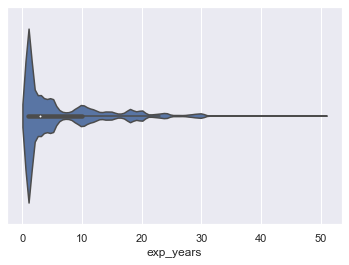

In [14]:
sns.violinplot(df['exp_years']);

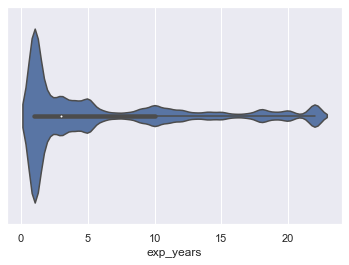

In [15]:
df['exp_years'] = winsorize(df['exp_years'], limits=[0,0.05])
sns.violinplot(df['exp_years']);

## Stop Duration

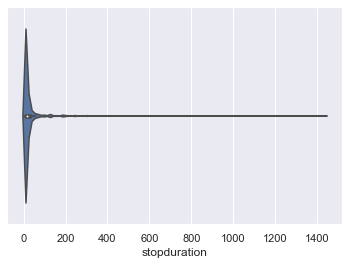

In [16]:
sns.violinplot(df['stopduration']);

In [17]:
minutes = 1400
min_per_hour = 60
minutes / min_per_hour

23.333333333333332

It appears some records are 24 hours, a possible typoe

In [18]:
df[df['stopduration'] > 120].shape

(20820, 27)

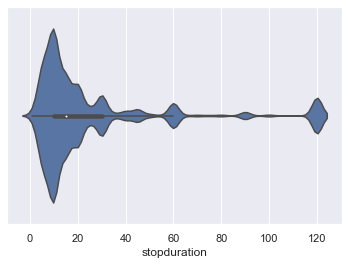

In [19]:
df['stopduration'] = winsorize(df['stopduration'], limits=[0,0.05])
sns.violinplot(df['stopduration']);

# Correlations

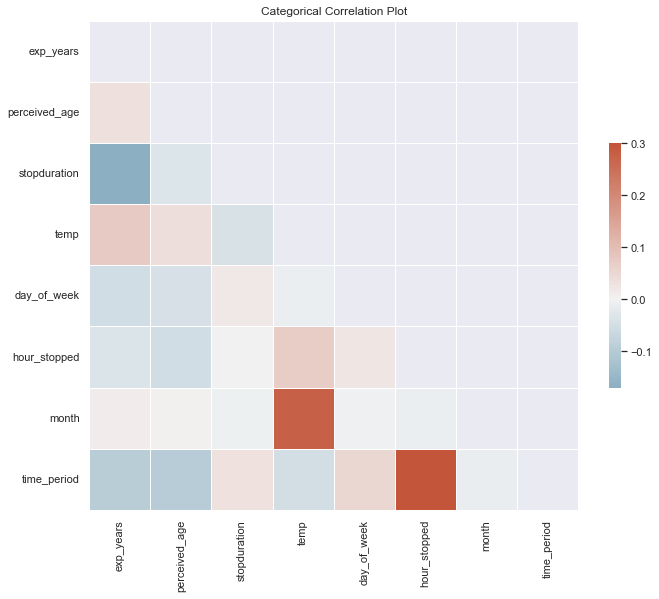

In [20]:
df_corr = df[numeric_features].corr()
corr_plotter(df_corr, 'Categorical Correlation Plot')

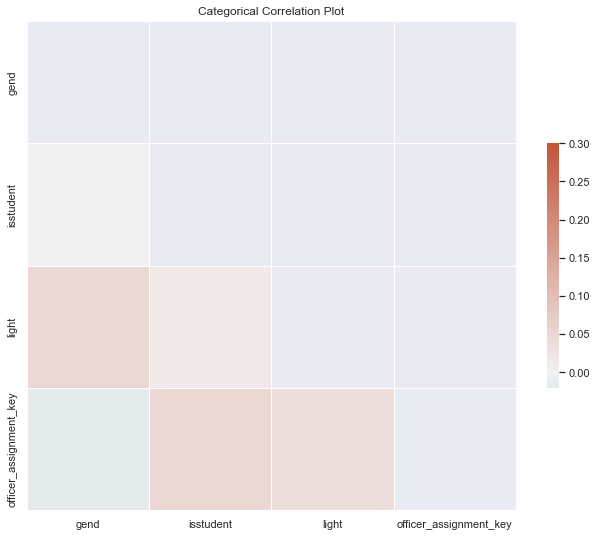

In [21]:
df_corr = df[nominal_features].corr(method='spearman')
corr_plotter(df_corr, 'Categorical Correlation Plot')

Glad to see there are no significant correlations.  With the strongest correlation being that of `Temp` + `Month` alongside `hour_stopped` + `time_period`.

# Breakdown of ethnicity
The following bar chart is based on the raw counts within the RIPA data set.

Text(0.5, 1.0, 'Raw Ratios from DataSet')

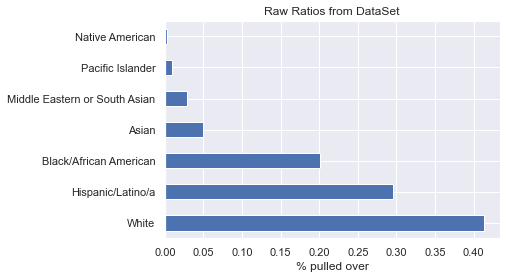

In [22]:
df['race'].value_counts(normalize=True).plot.barh()
plt.xlabel('% pulled over')
plt.title('Raw Ratios from DataSet')

To normalize the data, we take the total city population of San Diego from [US Census QuickFacts](https://www.census.gov/quickfacts/fact/table/sandiegocitycalifornia/PST045221) and multiply it with the percentage of each race.

In [23]:
ethnicity_perc = df['race'].value_counts(normalize=True).to_frame().reset_index()
ethnicity_perc

,index,race
0,White,0.413088
1,Hispanic/Latino/a,0.296118
2,Black/African American,0.200556
3,Asian,0.050054
4,Middle Eastern or South Asian,0.028497
5,Pacific Islander,0.009096
6,Native American,0.002590


In [24]:
ethnicity_count =  df['race'].value_counts().to_frame().reset_index()
ethnicity_count

,index,race
0,White,269520
1,Hispanic/Latino/a,193203
2,Black/African American,130853
3,Asian,32658
4,Middle Eastern or South Asian,18593
5,Pacific Islander,5935
6,Native American,1690


In [25]:
# merge the two Dfs above
ethnicity = ethnicity_count.merge(ethnicity_perc, left_on='index', right_on='index')
ethnicity.columns = ['ethnicity', 'pull_over_count', 'pull_over_percent']
ethnicity

,ethnicity,pull_over_count,pull_over_percent
0,White,269520,0.413088
1,Hispanic/Latino/a,193203,0.296118
2,Black/African American,130853,0.200556
3,Asian,32658,0.050054
4,Middle Eastern or South Asian,18593,0.028497
5,Pacific Islander,5935,0.009096
6,Native American,1690,0.002590


In [26]:
other = ethnicity.loc[4:,:].sum().to_frame().T
other

,ethnicity,pull_over_count,pull_over_percent
0,Middle Eastern or South AsianPacific IslanderN...,26218,0.040184


In [27]:
# rename other row "ethnicity" 
ethnicity = pd.concat([ethnicity[:4], other]).reset_index(drop=True)
ethnicity.loc[4,'ethnicity'] = 'Other'

# the following percentages are from US Census QuickFacts
ethnicity['pop_%'] = [0.423, 0.301, 0.061, 0.173, 0.042]

# city pop is from US Census QuickFacts
city_population = 1385922
ethnicity['pop'] = ethnicity['pop_%'] * city_population

# normalize ratio calculation
ethnicity['normalized_ratios'] = ethnicity['pull_over_count'] / ethnicity['pop']

# pull over rate relative to ethnic population
ethnicity['proportion'] = ethnicity['pull_over_percent'] / (ethnicity['pop_%'])

ethnicity

,ethnicity,pull_over_count,pull_over_percent,pop_%,pop,normalized_ratios,proportion
0,White,269520,0.413088,0.423,586245.006,0.45974,0.976567
1,Hispanic/Latino/a,193203,0.296118,0.301,417162.522,0.463136,0.983782
2,Black/African American,130853,0.200556,0.061,84541.242,1.547801,3.287799
3,Asian,32658,0.050054,0.173,239764.506,0.136209,0.289331
4,Other,26218,0.040184,0.042,58208.724,0.450414,0.956757


According to DataUSA.io*, as of 2020, African Americans only comprise 5.73% of the San Diego population while White (Non-HIspanics) make up the majority at 42.3% which is probably the reason why Whites make nearly 40+% of the pull RIPA data.  Asians are 3x more in population size yet they represent are pulled over 1/4 less than that of African American.


* DataUSA.io was utilized over raw census data such as that of Census Quick Facts due to DataUSA's precalculated ratios of white non-hispanic vs white hispanic.  US Census clumps up both groups into one and thus the calculations would be off.  Calculating such statistics is out the scope of this project due to the idea that DataUSA's data suffices.

 Pull Over Count

Text(0.5, 0, 'Counts within RIPA dataset')

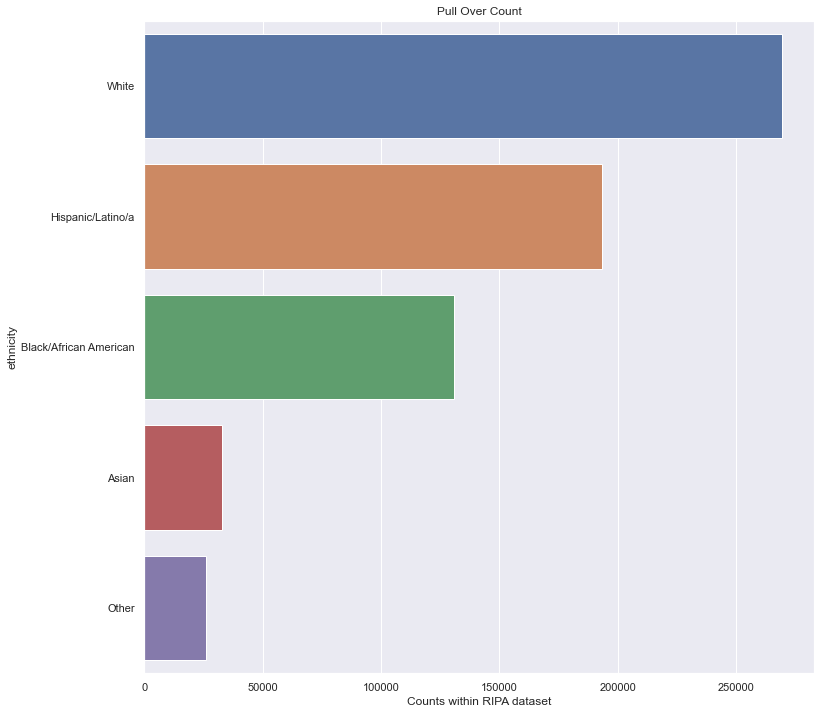

In [28]:
plt.figure(figsize=(12,12))
sns.barplot(y='ethnicity', x='pull_over_count', data=ethnicity.sort_values(by='pull_over_count', ascending=False), label='ethnicity')
plt.title('Pull Over Count')
plt.xlabel('Counts within RIPA dataset')


#### Ethnic Pull Over Count / Ethnic Population


Text(0.5, 0, 'Probability of being pulled over in proprtion to ethnicity')

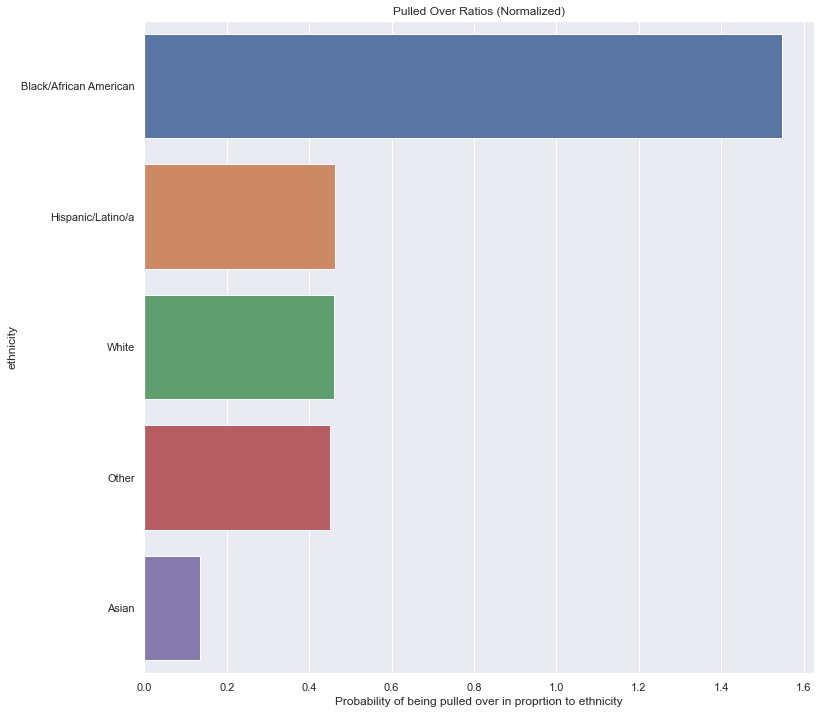

In [29]:
plt.figure(figsize=(12,12))
sns.barplot(y='ethnicity', x='normalized_ratios', data=ethnicity.sort_values(by='normalized_ratios', ascending=False), label='ethnicity')
plt.title('Pulled Over Ratios (Normalized)')
plt.xlabel('Probability of being pulled over in proprtion to ethnicity')


#### Ethnic Pull Over Ratio / Ethnic Population Ratio

Text(0.5, 0, 'Ethnic Pull Over Ratio / Ethnic Population Ratio')

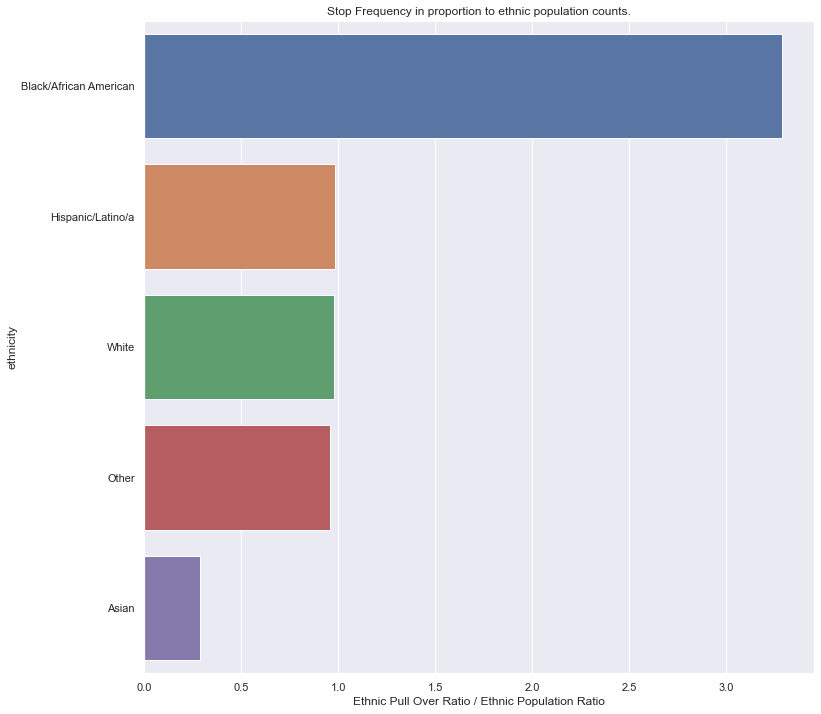

In [30]:
plt.figure(figsize=(12,12))
sns.barplot(y='ethnicity', x='proportion', data=ethnicity.sort_values(by='proportion', ascending=False), label='ethnicity')
plt.title('Stop Frequency in proportion to ethnic population counts.')
plt.xlabel('Ethnic Pull Over Ratio / Ethnic Population Ratio')


In [31]:
ethnicity.sort_values(by='proportion', ascending=False).loc[:,['ethnicity', 'proportion']]

,ethnicity,proportion
2,Black/African American,3.287799
1,Hispanic/Latino/a,0.983782
0,White,0.976567
4,Other,0.956757
3,Asian,0.289331


Black/African Americans are pulled over 3.28x more than their White Americans and Hispanic American counterparts; while Asian Americans are pulled over ¼ less than their White American and Hispanic American counterparts. 

# Age

Text(0.5, 1.0, 'Perceived Age by Ethnicity (Thickness represents count)')

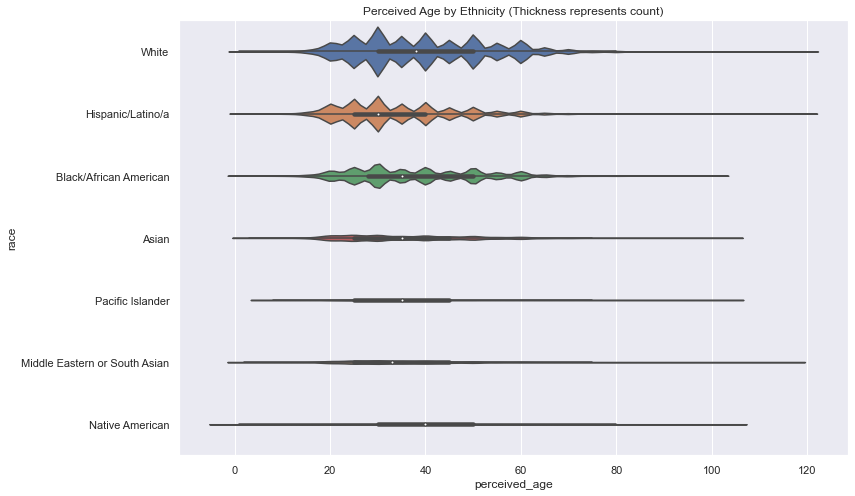

In [35]:
plt.figure(figsize=(12,8))
sns.violinplot(data=df, y=df['race'], x=df['perceived_age'], scale='count')
plt.title('Perceived Age by Ethnicity (Thickness represents count)')

# Day of the week
* 0 = Monday<br>
* 6 = Sunday

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

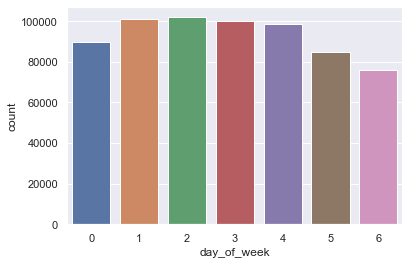

In [52]:
sns.countplot(df['day_of_week'])

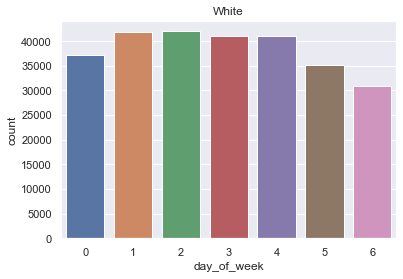

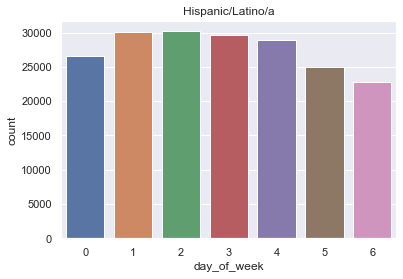

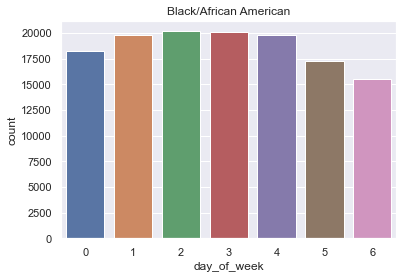

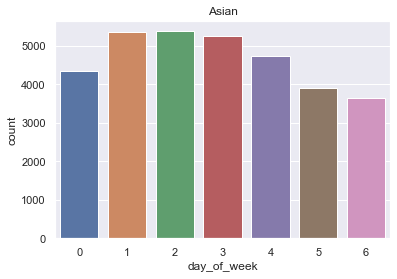

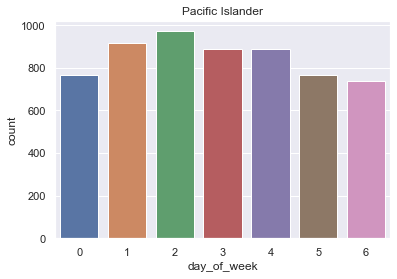

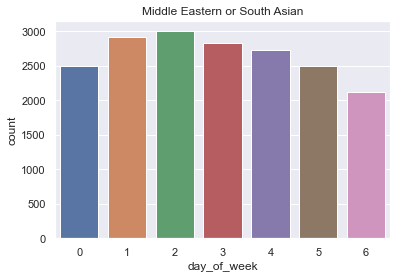

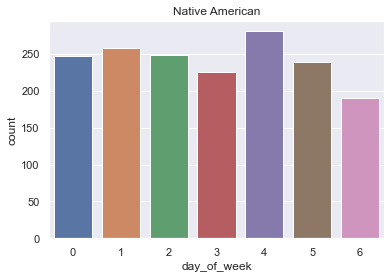

In [60]:
for race in races:
    scope = df.loc[df['race'] == race, 'day_of_week']
    sns.countplot(scope)
    plt.title(f'{race}')
    plt.show()

Other than Native Americans getting pulled over the most on Fridays, nothing strange stands out.  Days 5 and 6 (Saturday and Sunday) have the least amount of crime.  Days Tuesday, Wednesday, and Thursday have the most overall crime.

# Hours most stopped

<AxesSubplot:xlabel='hour_stopped'>

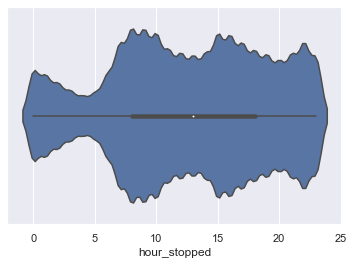

In [36]:
sns.violinplot(df['hour_stopped'])

Text(0.5, 1.0, 'Perceived Age by Ethnicity (Thickness represents count)')

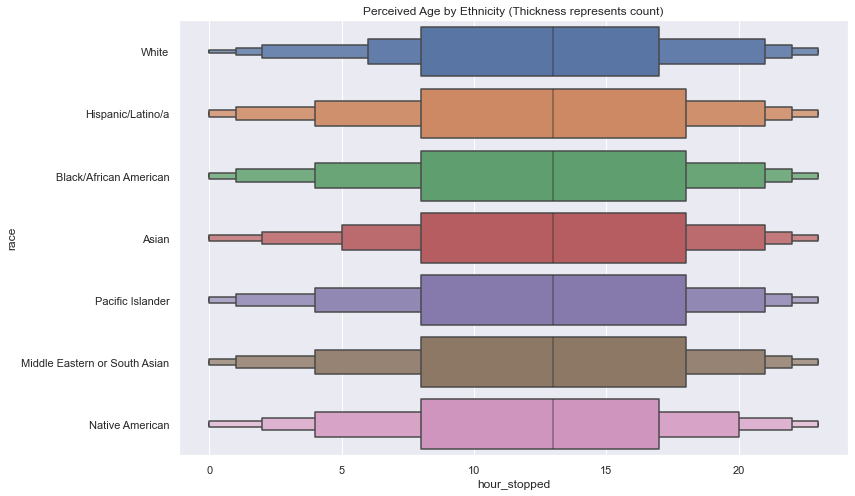

In [41]:
plt.figure(figsize=(12,8))
sns.boxenplot(data=df, y=df['race'], x=df['hour_stopped'])
plt.title('Perceived Age by Ethnicity (Thickness represents count)')

Stops beyond an hour might be distorted.

<AxesSubplot:xlabel='hour_stopped'>

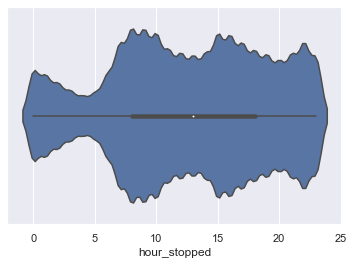

In [46]:
scope = df[df['hour_stopped'] < 60]

sns.violinplot(scope['hour_stopped'])

Text(0.5, 1.0, 'Perceived Age by Ethnicity (Thickness represents count)')

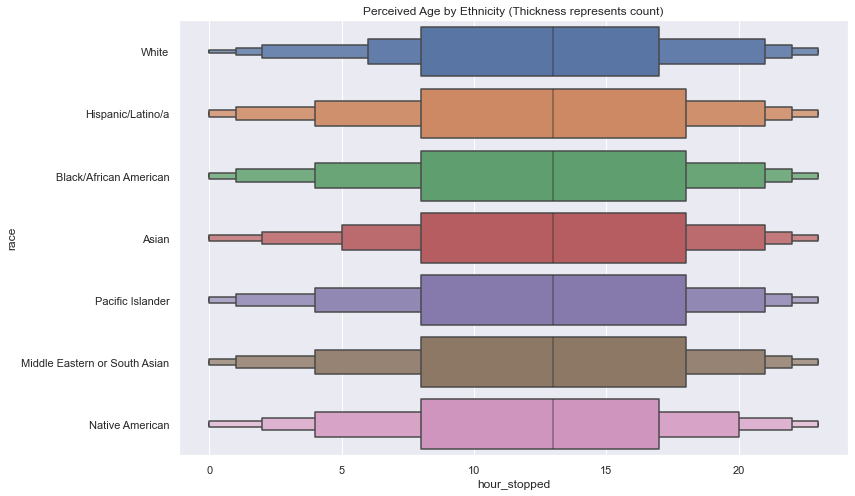

In [45]:
plt.figure(figsize=(12,8))
sns.boxenplot(data=scope, y=scope['race'], x=scope['hour_stopped'])
plt.title('Perceived Age by Ethnicity (Thickness represents count)')

Though the median for all ethnicities is the same though Whites and Asians tend to be released sooner than other ethnicities.  This is more so true with whites, as shown by its 4th tier whisker on the left.

Catch and Rapid Release (in order):
1) White
2) Asian
3) Native American

Black/African American, Pacific Islanders, and MIddle Easter or South Asian share the same catch and release rates.

# Month Trends

Seems that all years have random counts.

In [ ]:
# create year column to seperate the years
df['year'] = df['date_stop'].astype('datetime64').dt.year
years = df['year'].unique()


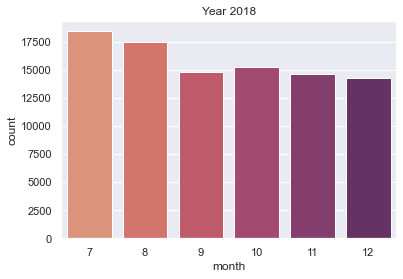

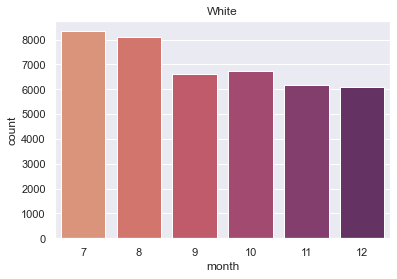

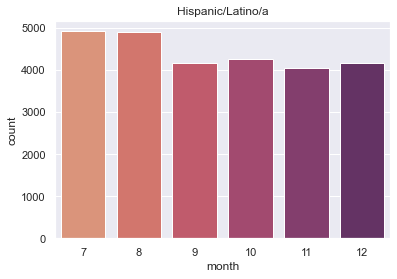

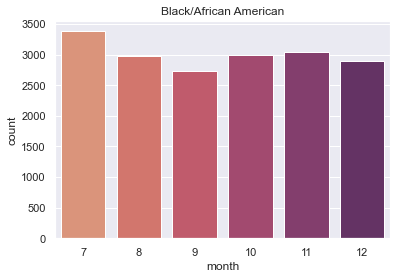

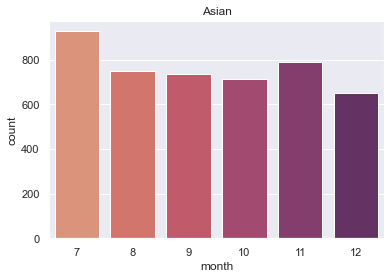

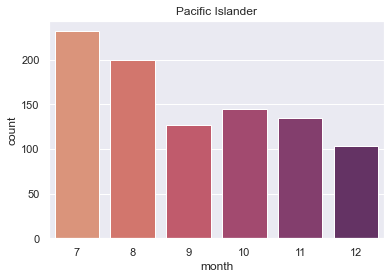

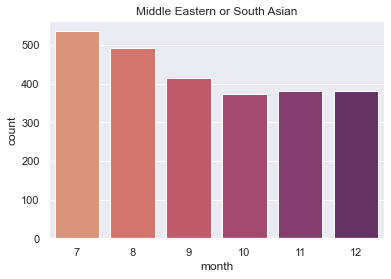

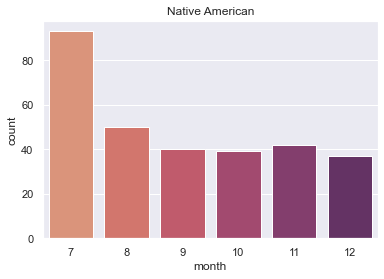

In [79]:
year = 2018
scope = df[df['year'] == year]

sns.countplot(scope['month'], palette='flare')
plt.title(f'Year {year}')
plt.show()

for race in races:
    scope2 = scope[scope['race'] == race]
    
    sns.countplot(scope2['month'], palette='flare')
    plt.title(f'{race}')
    plt.show()

Nothing out of the ordinary.  It appears that officers were very active the three months after RIPA was initilized then crime dropped.

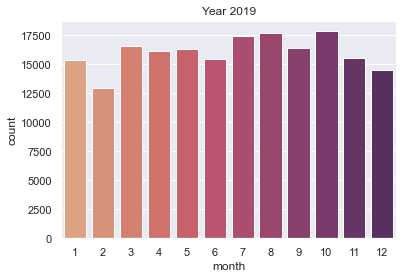

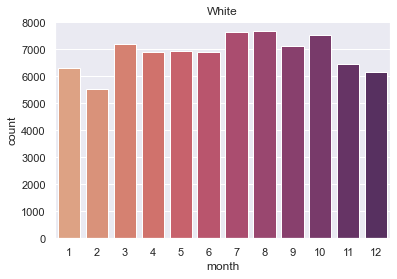

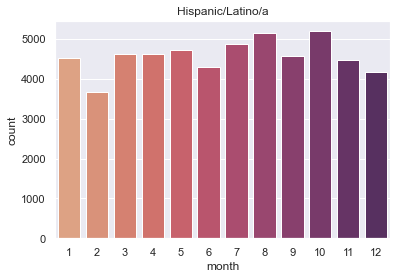

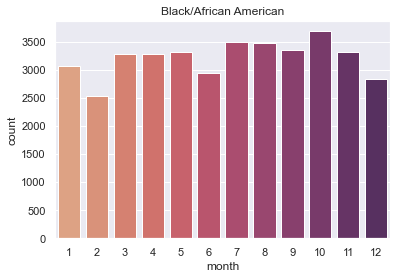

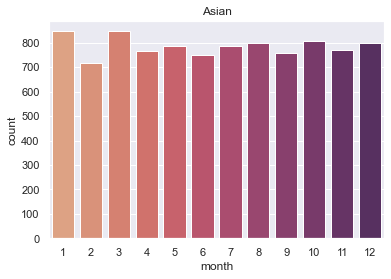

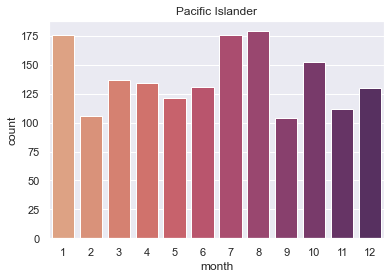

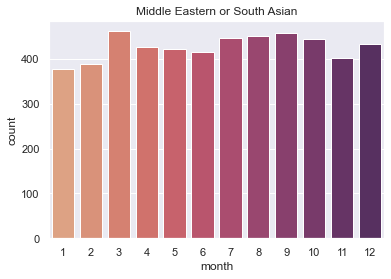

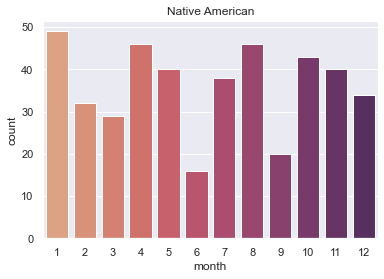

In [82]:
year = 2019
scope = df[df['year'] == year]

sns.countplot(scope['month'], palette='flare')
plt.title(f'Year {year}')
plt.show()

for race in races:
    scope2 = scope[scope['race'] == race]
    
    sns.countplot(scope2['month'], palette='flare')
    plt.title(f'{race}')
    plt.show()

It appears that months, 7-10 (July through October) have the highest counts.  This is most likely due to the fact that days are longer and people tend to stay out longer.

Skipping 2020 due to Covid Restrictions that year creating various differences from normal years and thus unable to extract any information due to randomness.

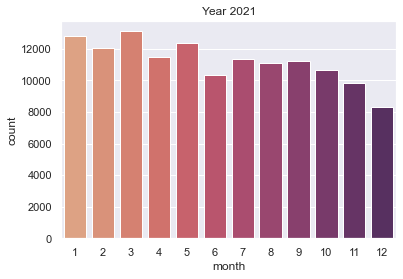

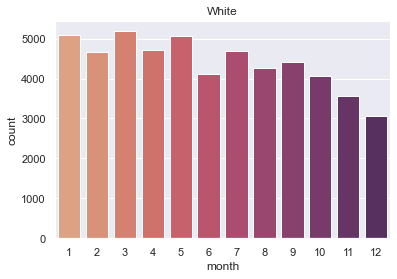

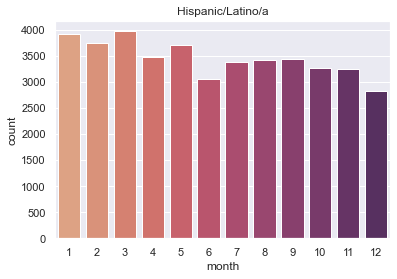

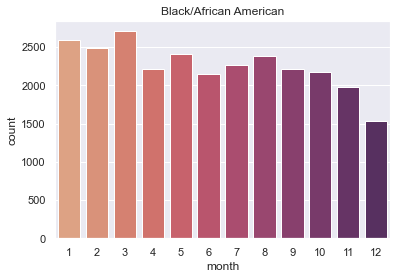

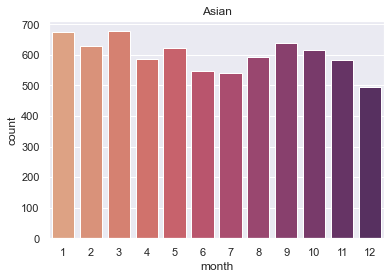

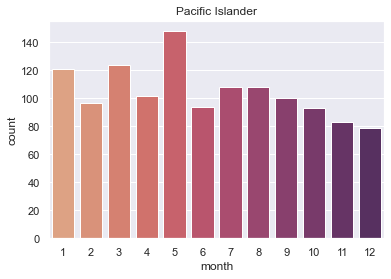

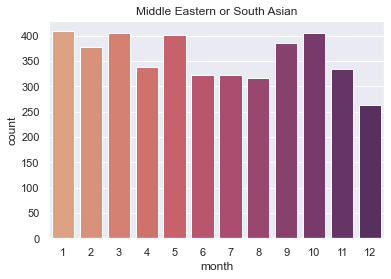

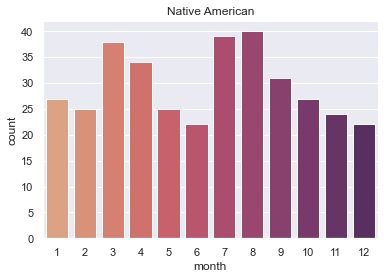

In [81]:
year = 2021
scope = df[df['year'] == year]

sns.countplot(scope['month'], palette='flare')
plt.title(f'Year {year}')
plt.show()

for race in races:
    scope2 = scope[scope['race'] == race]
    
    sns.countplot(scope2['month'], palette='flare')
    plt.title(f'{race}')
    plt.show()

It appears that the first 6 months of 2021 doesn't follow that of 2019, which is what we assume to be a normal year. 2021 isn't normal due to the fact people were in mandatory lockdown throughout 2020 and such restrictions were removed in early 2021.

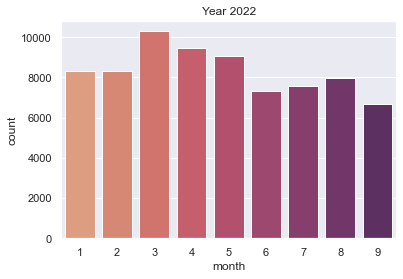

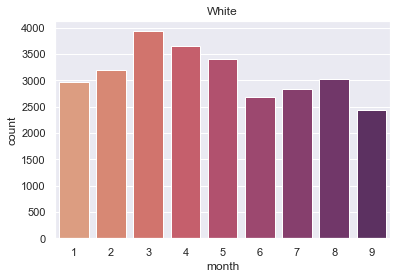

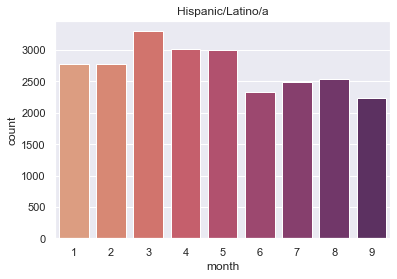

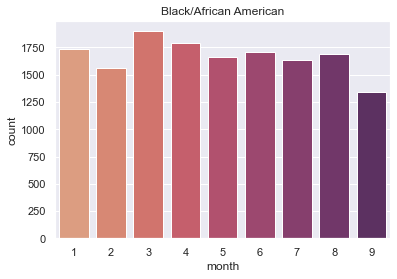

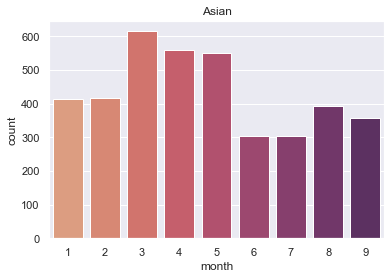

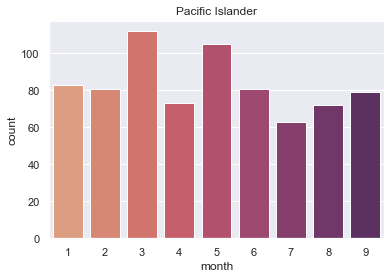

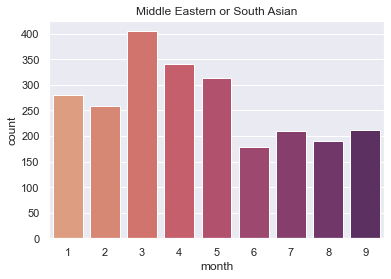

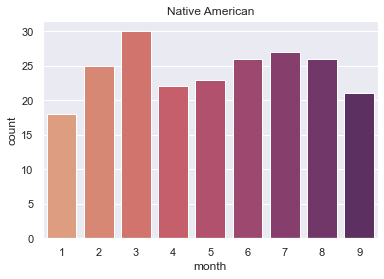

In [83]:
year = 2022
scope = df[df['year'] == year]

sns.countplot(scope['month'], palette='flare')
plt.title(f'Year {year}')
plt.show()

for race in races:
    scope2 = scope[scope['race'] == race]
    
    sns.countplot(scope2['month'], palette='flare')
    plt.title(f'{race}')
    plt.show()

Surprisingly March it appears that the month of March was SDPD's busiest month.  July-August dont' appear as busy as 2019.  

Let's do a year over year comparison to compare the months.

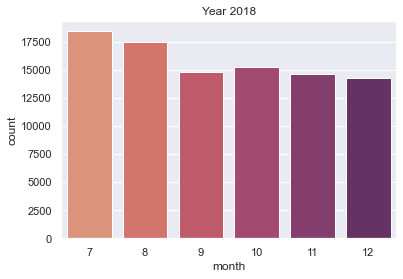

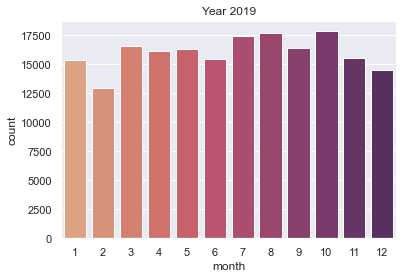

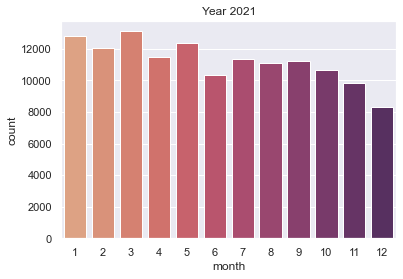

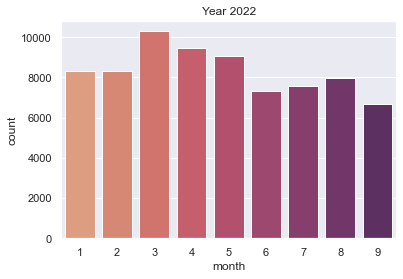

In [85]:
for year in years:
    # pandemic year was not normal, and thus is uncomparible to other years
    if year != 2020:
        scope = df[df['year'] == year]

        sns.countplot(scope['month'], palette='flare')
        plt.title(f'Year {year}')
        plt.show()

It appears that there is a new normal for now.  Maybe in part due to people are afraid in the winter of the various diseases associated with winter.  Diseases and viruses such as the Flu and Covid.

# Crime by Light

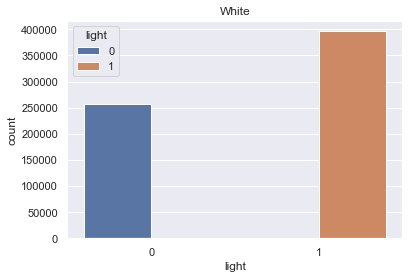

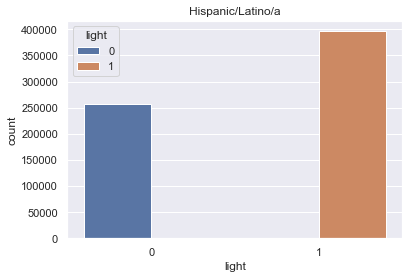

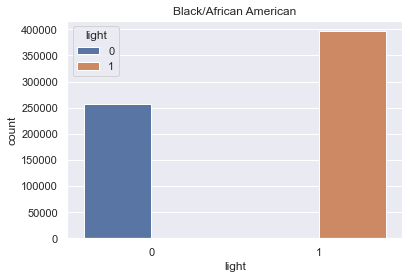

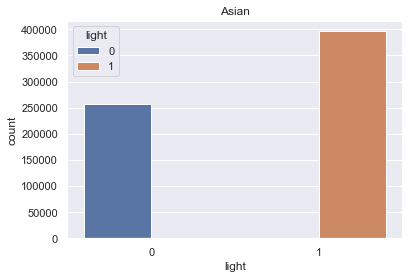

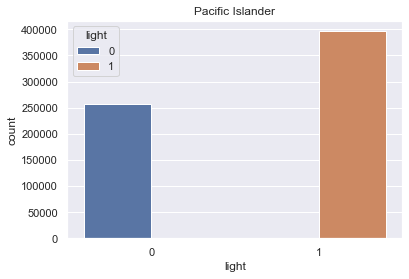

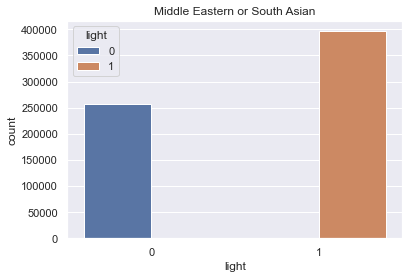

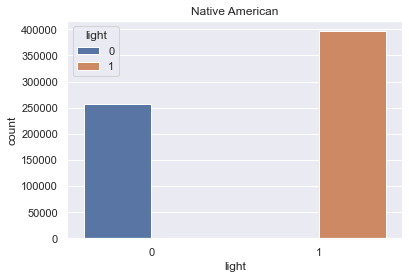

In [90]:
for race in races:
    scope = df[df['race'] == race]
    
    sns.countplot(df['light'], hue=df['light'])
    plt.title(f'{race}')
    plt.show()

Again, more crime when there is light.  Goes with the pattern that we saw from the months of 2019 (July - Oct).

# Reason for stop by Race

In [112]:
race_x_reason_for_stop = df.groupby(['race','reason_for_stop']).count().iloc[:,1].to_frame().reset_index()
race_x_reason_for_stop = race_x_reason_for_stop.rename(columns={'pid':'count'})
race_x_reason_for_stop.head(5)

,race,reason_for_stop,count
0,Asian,Consensual Encounter resulting in a search,272
1,Asian,Determine whether the student violated school ...,3
2,Asian,Investigation to determine whether the person ...,402
3,Asian,Knowledge of outstanding arrest warrant/wanted...,268
4,Asian,Known to be on Parole / Probation / PRCS / Man...,219


In [126]:
scopes = []
for race in races:
    scope = race_x_reason_for_stop[race_x_reason_for_stop['race'] == race]
    scope.loc[:, 'proportion'] = scope.loc[:,'count'] / scope['count'].sum()
    scopes.append(scope)

race_x_reason_for_stop = pd.concat(scopes)
del(scopes)

,race,reason_for_stop,count,proportion
42,White,Consensual Encounter resulting in a search,2983,0.011068
43,White,Determine whether the student violated school ...,14,0.000052
44,White,Investigation to determine whether the person ...,3769,0.013984
45,White,Knowledge of outstanding arrest warrant/wanted...,2464,0.009142
46,White,Known to be on Parole / Probation / PRCS / Man...,2629,0.009754


In [156]:
for race in races:
    display(race_x_reason_for_stop.loc[race_x_reason_for_stop['race']==race,:].tail(2))

,race,reason_for_stop,count,proportion
48,White,Reasonable Suspicion,153116,0.568106
49,White,Traffic Violation,104537,0.387864


,race,reason_for_stop,count,proportion
21,Hispanic/Latino/a,Reasonable Suspicion,84626,0.438016
22,Hispanic/Latino/a,Traffic Violation,99278,0.513853


,race,reason_for_stop,count,proportion
13,Black/African American,Reasonable Suspicion,75609,0.577816
14,Black/African American,Traffic Violation,47907,0.366113


,race,reason_for_stop,count,proportion
6,Asian,Reasonable Suspicion,9776,0.299345
7,Asian,Traffic Violation,21713,0.664860


,race,reason_for_stop,count,proportion
40,Pacific Islander,Reasonable Suspicion,2674,0.450548
41,Pacific Islander,Traffic Violation,2983,0.502612


,race,reason_for_stop,count,proportion
28,Middle Eastern or South Asian,Reasonable Suspicion,5248,0.282257
29,Middle Eastern or South Asian,Traffic Violation,12948,0.696391


,race,reason_for_stop,count,proportion
34,Native American,Reasonable Suspicion,1129,0.668047
35,Native American,Traffic Violation,444,0.262722


It appears the reason why most White Americans and Black Americans are pulled over, roughly 57% of the time is due to `Reasonable Suspicion`, while `Asians` (East and South East Asians) and `Middle Eastern or South Asians` are mostly pulled over due to actual traffic violations.  The most unusual thing here is that Nativ Americans are pulled over for `Reasonable Suspicion` nearly 67% of the time!